## Sample Visualization. 

There are five different Samples. Each Sample contains one hundreds of spots, each with a sigle spectrum. Each spectrum was assigned a "good", "bad" or "maybe" label by the user. This notebook visualizes 

In [2]:
import os
import git
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ramanbox.raman.sample_builder import SampleBuilder
from ramanbox.raman.sample import Sample
from ramanbox.raman.constants import Label
from fit_visualization import FittingVisualizer
from helper_funs import make_df, make_Xy
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
import copy
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # 6

In [3]:
random.seed(42)

## Data Loading

Loading data into memory

In [4]:
labeled_data_dir = 'data'
output_dir = '../'

In [5]:
#load labeled data 
net_cdf_files = glob.glob(os.path.join(labeled_data_dir, '*.nc'))
sample_list = []
for file in net_cdf_files:
    sample_list.append(Sample.build_from_netcdf(file))

In [6]:
# store wavenumbers in variable 
wavenumbers = sample_list[-1].spot_list[0].spectrum_list[0].wavenumbers

In [7]:
# print index and name of loaded samples 
print('Loaded Samples')
for index, sample in enumerate(sample_list):
    print(index, sample.name)

Loaded Samples
0 20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_scan_1sec_exposure
1 20200226_moxtek_R6G_3mM_60X_10mW_20x20_scan_1sec_exposure
2 20200226_plasmore_R6G_10^-5mM_60X_10mW_20x20_scan_1sec_exposure
3 20200226_plasmore_R6G_10^-5mM_60X_20mW_20x20_scan_1sec_exposure
4 20200226_plasmore_R6G_3mM_60X_10mW_20x20_scan_1sec_exposure


## Count Number of good bad and maybe labels

In [123]:
sample_df = make_df(sample_list)

In [124]:
sample_df.head()

,spectrum,label,x_pos,y_pos,name
0,"[18.756165120223844, 19.054400977376893, 19.57...",Label.GOOD,0,0,20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_sca...
1,"[16.40678608045157, 16.39639504180089, 16.3663...",Label.GOOD,1,0,20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_sca...
2,"[16.140213015032, 16.179035595141684, 16.15268...",Label.GOOD,2,0,20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_sca...
3,"[18.715378414044686, 19.182728800518184, 18.75...",Label.GOOD,3,0,20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_sca...
4,"[17.851638678373543, 18.274909886172818, 18.05...",Label.GOOD,4,0,20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_sca...


In [132]:
sample_df['label_value'] = sample_df['label'].apply(lambda x: x.value)

In [139]:
grouped_index = sample_df.groupby('label_value').agg(['count'])
grouped_index.index = [Label(value).name for value in grouped_index.index]
grouped_index

,spectrum,label,x_pos,y_pos,name
,count,count,count,count,count
BAD,936,936,936,936,936
GOOD,940,940,940,940,940
MAYBE,119,119,119,119,119


## Visualize Training Substrates

In [140]:
grouped_index.sum()

spectrum  count    1995
label     count    1995
x_pos     count    1995
y_pos     count    1995
name      count    1995
dtype: int64

In [8]:
y_train_maybe = make_df([sample_list[1]])['label'].apply(lambda x: x.value).to_numpy()

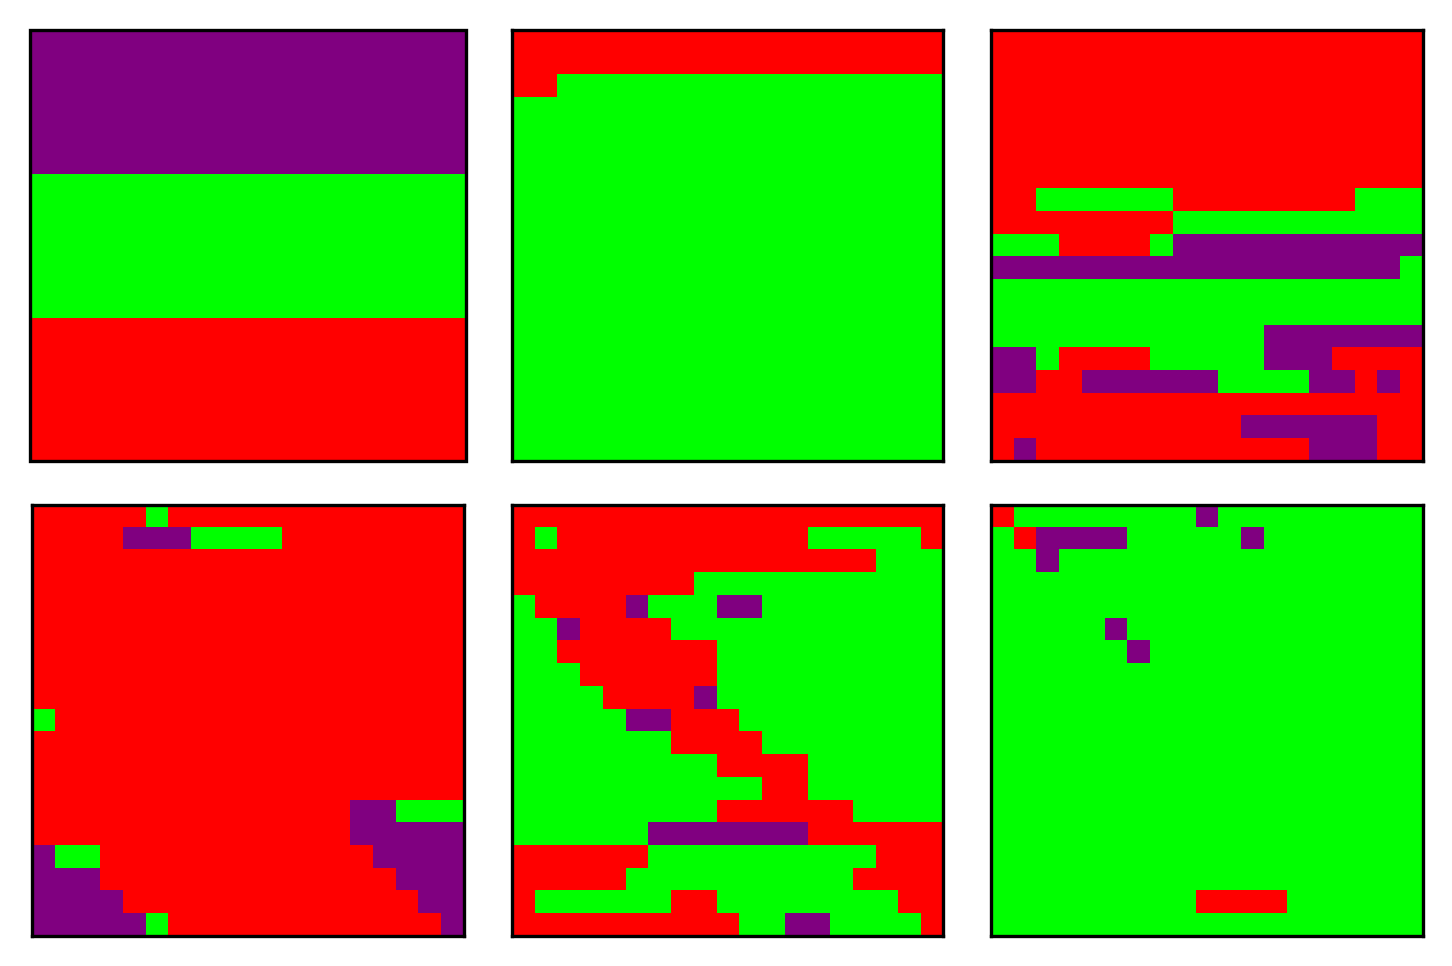

In [16]:
#predicting substrate  
from matplotlib import colors
import matplotlib 
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

color_key = {0: 'red', 1: 'lime', 2: 'purple'}
fig, axes = plt.subplots(2,3, figsize=(6,4), dpi=300)
#axes.flatten()[-1].remove()
#fig.subplots_adjust(bottom=0.8)
#cbar_x = fig.add_axes() #[0, 1, 1, 0.1])
j = 0
axes_iter = iter(axes.flatten())
next(axes_iter)
for ax, sample in zip(axes_iter, sample_list):
    j += 1
    cmap = ListedColormap(['k', 'w', 'r'])
    label = 'Sample ' + str(j)
    #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center_baseline', fontsize=10, color = 'white')
    z = make_df([sample])['label'].apply(lambda x: x.value).to_numpy()
    a = int(np.sqrt(len(z)))
    if a*a < len(z):
        z_list = list(z)
        for i in range(a*a, len(z)):
            z_list.pop()
        z = np.array(z_list)
    elif a*a > len(z):
        z_list = z
        for i in range(len(z), a*a):
            z_list.append(2)
        z = np.array(z_list)   
    x = np.reshape(z,(a,a))
    #plt.cm.ScalarMappable('tab10')
    color_order = []
    indices_found = []
    for num in z:
        if num not in indices_found:
            color_order.append(color_key[num])
            indices_found.append(num)
        if len(color_order) >= 3:
            break

    cmap2 = colors.ListedColormap(color_order)
    #bounds=[-0.5,0.5,1.5, 3]
    #norm = colors.BoundaryNorm(bounds, cmap2.N)
    ax.imshow(x,cmap=cmap2) #, norm=norm)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelright=False, labelleft=False, labelbottom=False,labeltop=False) # removes tick marks
#fig.tight_layout()
last_axis = axes.flatten()[0]
fig.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=ListedColormap(['red', 'lime', 'purple'])), orientation='vertical', ticks=[], cax=last_axis) #  label="Bad Good Maybe") #ticks=[], location="bottom") #, label="Bad           Maybe            Good", location="bottom")
#gs = gridspec.GridSpec(2,3)
# last_axis.set_position(gs[-1].get_position(fig))
# last_axis.set_subplotspec(gs[-1])              # only necessary if using tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1, left=None, bottom=None, right=None, top=None)

plt.savefig(os.path.join(output_dir, 'substrates_map.svg'))

#comparison
#plt.matshow(y_correct)

In [113]:
a

19

In [18]:
params = {'learning_rate': 0.0167,
         'max_depth': 4,
         'max_features': 5,
         'min_sample_leaf': 1,
         'min_sample_split': 1,
         'n_estimators': 780,
         'random_state': 42,
         'subsample': 0.75}

### Now train model on each out of sample, test on the others and compute metrics

In [19]:
sample_names_short = []
sample_names_long = []
for index, sample in enumerate(sample_list):
    sample_names_short.append('Sample ' + str(index))
    sample_names_long.append(sample.name)
# build train_test tuples for each sample 
train_test_dict = {}
for i in range(len(sample_list)):
    train_samples = []
    test_samples = []
    for j in range(len(sample_list)):
        if i == j:
            test_samples.append(sample_list[j])
        else:
            train_samples.append(sample_list[j])
    train_test_dict[i] = (make_Xy(make_df(train_samples)), make_Xy(make_df(test_samples)))

In [20]:
# calculate metrics 
df = pd.DataFrame()
fitvis_dict = {}
for i in train_test_dict.keys():
    Xy_train, Xy_test = train_test_dict[i]
    X_train, y_train = Xy_train
    X_test, y_test = Xy_test
    xgb = XGBClassifier(**params)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_probs = xgb.predict_proba(X_test)[:,1]
    fitvis = FittingVisualizer(X_test, y_test, y_pred, y_scores=y_probs, save_data=False)
    fitvis_dict[i] = fitvis
    tmp_df = fitvis.get_stats_df()
    tmp_df['frac pos'] = sum(y_test)/len(y_test)
    df = df.append(tmp_df)
df.index = sample_names_short
df['test samples'] = sample_names_long

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
df['test samples'] = sample_names_long

In [22]:
df.to_excel(os.path.join(output_dir, 'test_sample_result.xlsx'))

In [23]:
from enum import Enum
class ResultType(Enum):
    MAYBE = 0
    TN = 1
    FN = 2
    FP = 3
    TP = 4

In [24]:
X, y = make_Xy(make_df(train_samples), remove_maybe_uncat=False)
X, y_pred = make_Xy(make_df(train_samples), remove_maybe_uncat=True)

In [25]:
ResultType.MAYBE.name

'MAYBE'

In [26]:
def make_y_vec_result(y_true_with_maybe, y_pred):
    result_label = []
    tracking_i = 0 
    for true_label in y_true_with_maybe:
        if true_label == 2: #maybe
            result_label.append(ResultType.MAYBE)
            continue
        elif true_label == 0: # bad
            if y_pred[tracking_i] == 1:
                result_label.append(ResultType.FP)
            else:
                result_label.append(ResultType.TN) #FN
            tracking_i += 1 
        else: # good 
            if y_pred[tracking_i] == 1: 
                result_label.append(ResultType.TP) # FP
            else:
                result_label.append(ResultType.FN)
            tracking_i += 1 
        
    y_vec_result = [e.value for e in result_label]
    return y_vec_result

In [27]:
result_vec_list = []
for index, fv in fitvis_dict.items():
    _, y_true_with_maybe = make_Xy(make_df([sample_list[index]]), remove_maybe_uncat=False)
    result_vec_list.append(make_y_vec_result(y_true_with_maybe, fv.y_pred))

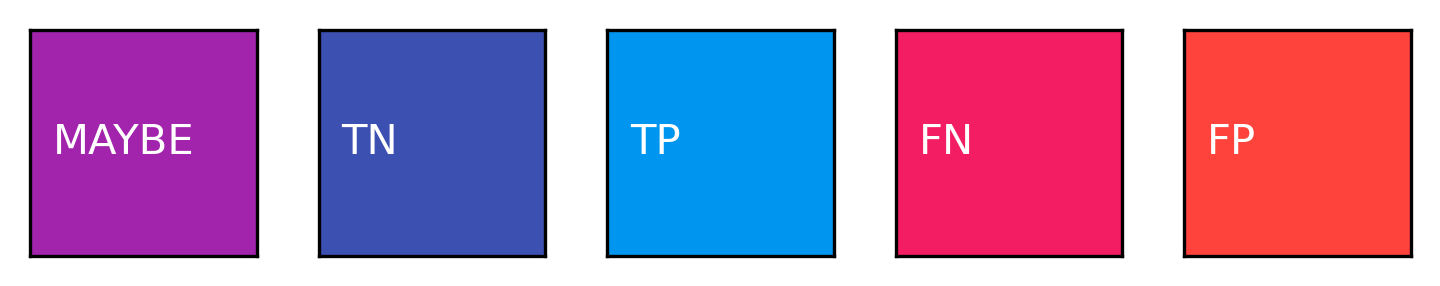

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [112]:
color_key_int = {ResultType.MAYBE.value: np.array((162, 36, 173)),
                 ResultType.TN.value: np.array((60, 80, 177)),
                 ResultType.TP.value: np.array((0, 149, 239)),
                 ResultType.FN.value: np.array((243, 29, 100)),  
                 ResultType.FP.value: np.array((254, 67, 60))} 

fig, axes = plt.subplots(1, 5, figsize=(6, 1), dpi=300)
axes_iter = iter(axes.flatten())
for int_num, color_array in color_key_int.items():
    ax = next(axes_iter)
    x = np.ndarray(shape=(1, 1, 3), dtype=int)
    x[0][0] = color_array
    label = ResultType(int_num)
    plt.figure()
    ax.imshow(x)
    ax.annotate(label.name, (0.1, 0.5), xycoords='axes fraction', va='center', fontsize=10, color = 'white')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelright=False, labelleft=False, labelbottom=False,labeltop=False) # removes tick marks

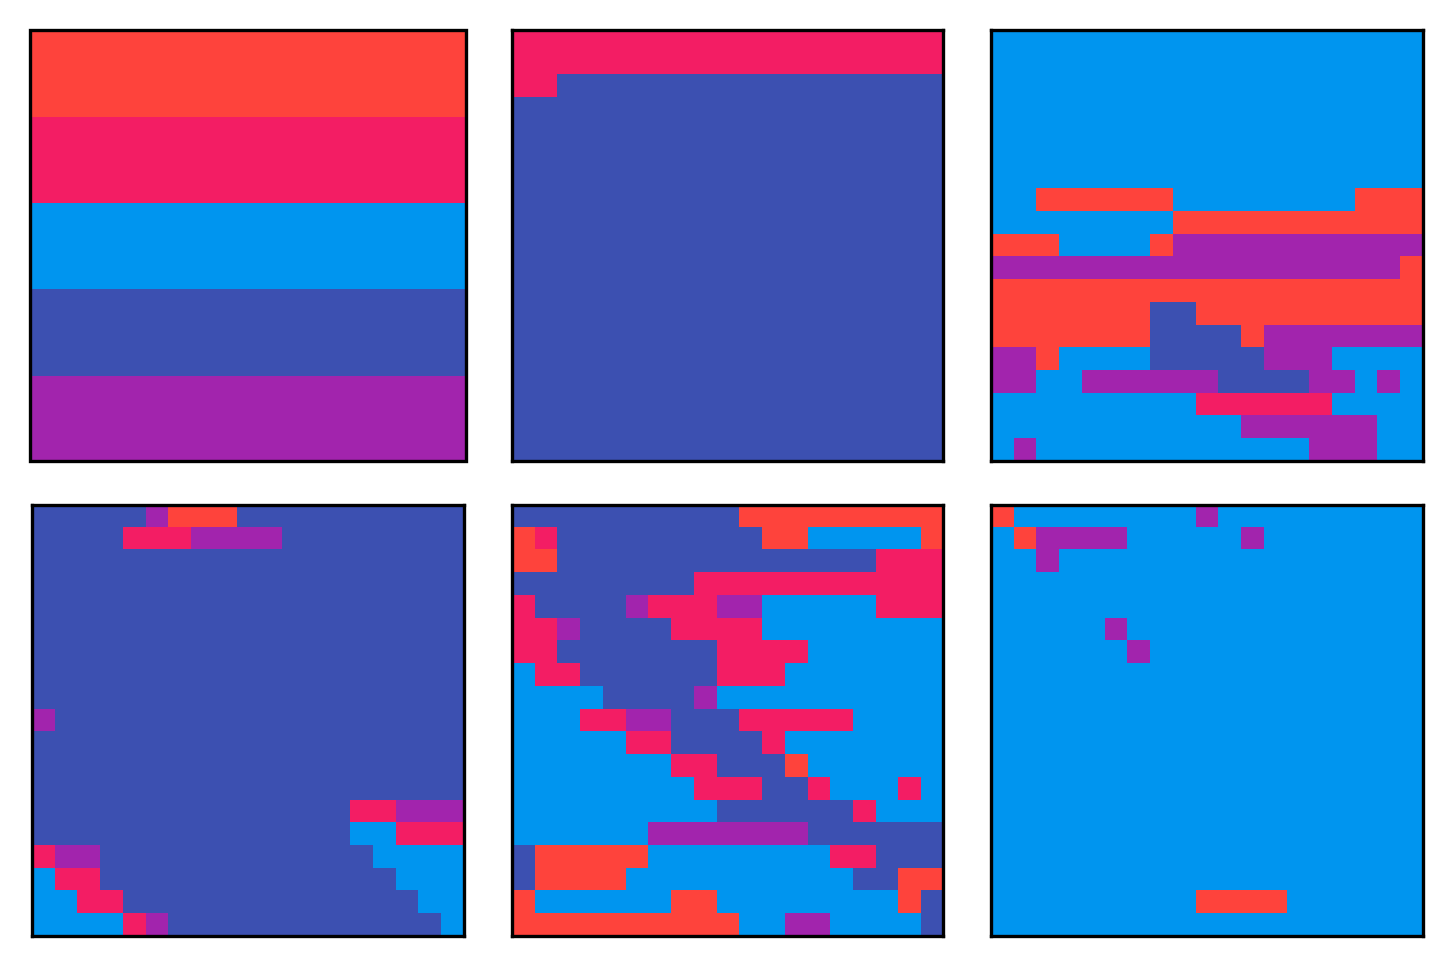

In [115]:
#predicting substrate  
from matplotlib import colors
import matplotlib 
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

substrate_num = 0 
substrate_image = np.ndarray(shape=(19,19,3), dtype=int)
fig, axes = plt.subplots(2,3, figsize=(6,4), dpi=300)
axes_iter = iter(axes.flatten()) # skip first axis 
next(axes_iter)

for ax, result_vec in zip(axes_iter, result_vec_list):
    substrate_num += 1
    ax.set_box_aspect(1)
    label = 'Sample ' + str(substrate_num)
    result_vec_iter = iter(result_vec)
    for i in range(substrate_image.shape[0]):
        for j in range(substrate_image.shape[1]):
            substrate_image[i,j] = color_key_int[next(result_vec_iter)]
            
    ax.imshow(substrate_image)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelright=False, labelleft=False, labelbottom=False,labeltop=False) # removes tick marks

fig.subplots_adjust(hspace=0.1, wspace=0.1, left=None, bottom=None, right=None, top=None)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=ListedColormap(list(color_key.values()))), orientation='vertical', ticks=[], cax=axes.flatten()[0]) #  label="Bad Good Maybe") #ticks=[], location="bottom") #, label="Bad           Maybe            Good", location="bottom")

plt.savefig(os.path.join(output_dir, 'Predictions.svg'))


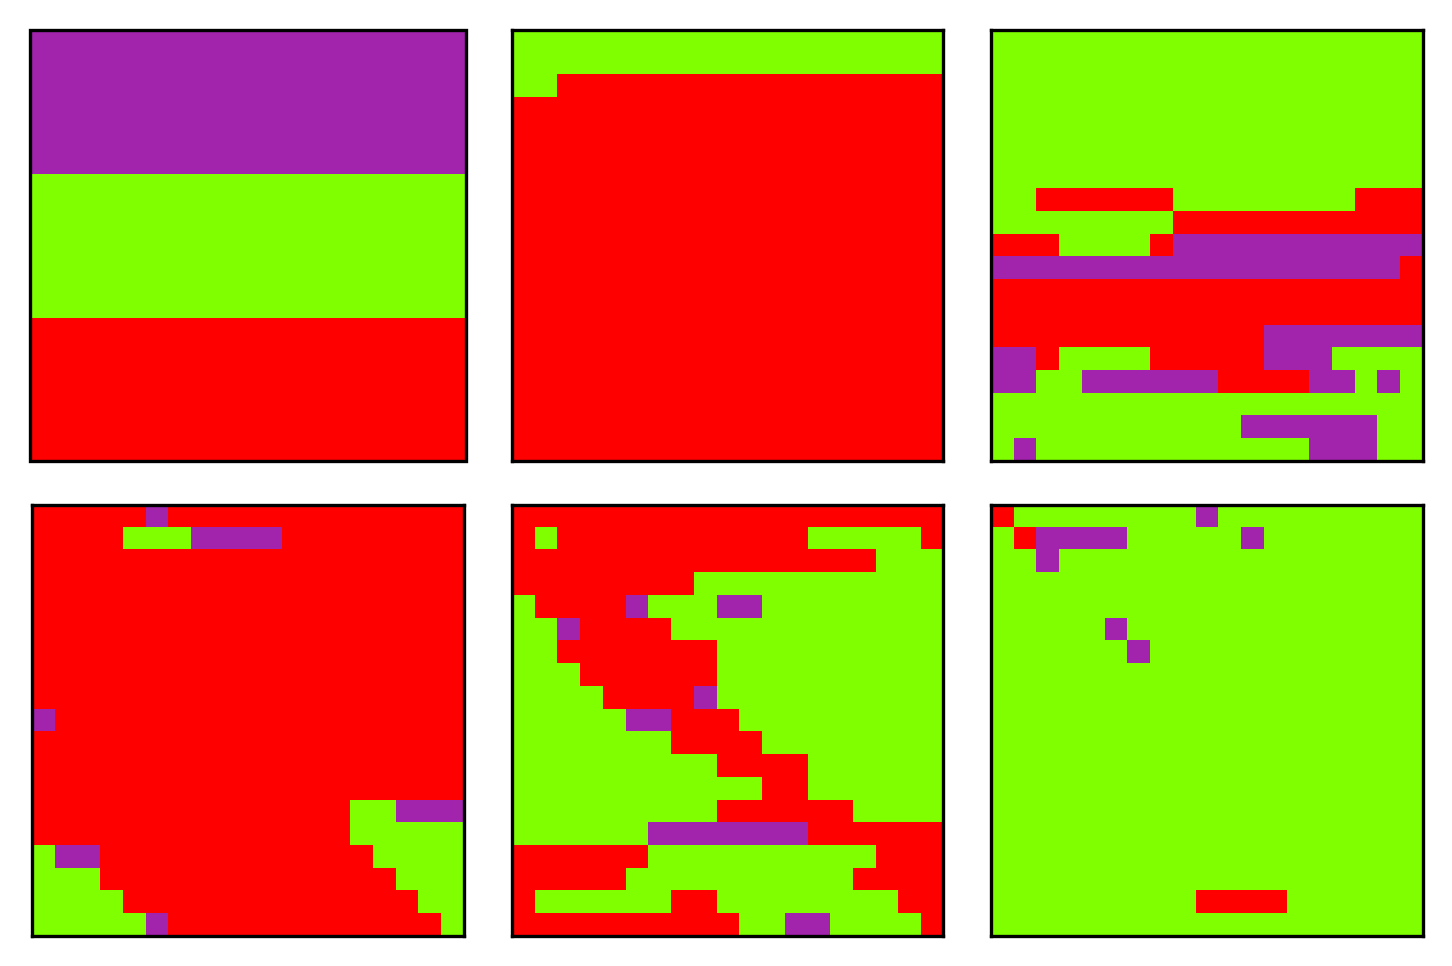

In [120]:
#predicting substrate  
from matplotlib import colors
import matplotlib 
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

color_key_int = {0: np.array((255, 0, 0)), 1: np.array((127, 255, 0)), 2: np.array((162, 36, 173))}
color_key_float = {0: np.array((255, 0, 0))/255, 1: np.array((127, 255, 0))/255, 2: np.array((162, 36, 173))/255}

substrate_num = 0 
substrate_image = np.ndarray(shape=(19,19,3), dtype=int)
fig, axes = plt.subplots(2,3, figsize=(6,4), dpi=300)
axes_iter = iter(axes.flatten()) # skip first axis 
next(axes_iter)
for ax, sample in zip(axes_iter, sample_list):
    substrate_num += 1
    ax.set_box_aspect(1)
    label = 'Sample ' + str(substrate_num)
    X, y = make_Xy(make_df([sample]), remove_maybe_uncat=False)
    y_iter = iter(y)
    for i in range(substrate_image.shape[0]):
        for j in range(substrate_image.shape[1]):
            substrate_image[i,j] = color_key_int[next(y_iter)]
            
    ax.imshow(substrate_image)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelright=False, labelleft=False, labelbottom=False,labeltop=False) # removes tick marks

fig.subplots_adjust(hspace=0.1, wspace=0.1, left=None, bottom=None, right=None, top=None)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=None, cmap=ListedColormap(list(color_key_float.values()))), orientation='vertical', ticks=[], cax=axes.flatten()[0]) #  label="Bad Good Maybe") #ticks=[], location="bottom") #, label="Bad           Maybe            Good", location="bottom")
plt.savefig(os.path.join(output_dir, 'substrates_map.svg'))

#comparison
#plt.matshow(y_correct)

In [31]:
print(color_order)

[(0.996078431372549, 0.2627450980392157, 0.23529411764705882), (0.0, 0.5843137254901961, 0.9372549019607843), (0.6352941176470588, 0.1411764705882353, 0.6784313725490196)]
